<h2>Problem Statement</h2>

<b>Can we predict if an applicant is approved for a loan, and if so, what factors influence loan approval?</b>

<h2>EDA</h2>

<h3>Cleaning & Pre-Processing</h3>
<i>All of these steps should've been done in the last assignment - sorry for doing them here!</i>

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# For combining pipelines after encoding
from sklearn.compose import make_column_selector as selector

sns.set(style="whitegrid")

In [226]:
df = pd.read_csv('playground-series-s4e10/train.csv')
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [227]:
# Renaming columns for easier understanding
df = df.rename(columns={'cb_person_default_on_file': 'history_of_default', 'cb_person_cred_hist_length': 'cred_hist_length'})
df.head() # Confirming changes

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,history_of_default,cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [228]:
df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [229]:
# From the correlation map from last assignment, person_age and credit_hist_length have a high correlation (> 0.88)
# This essentially shows us that these predictors measure the same thing. I will drop person_age
# Since credit_hist_length will be more directly related to loan decisions
df = df.drop(['person_age'], axis=1)

In [230]:
# Using Z-Scores to remove outliers
# These predictors are most likely to have outliers and affect the loan status
from scipy import stats
z_emp_length = np.abs(stats.zscore(df['person_emp_length']))
print(f'Z-Scores of Employment Length:\n {z_emp_length} \n')

df['z_emp_length'] = z_emp_length
df.head() # Confirming changes

Z-Scores of Employment Length:
 0        1.187200
1        0.328047
2        0.833130
3        2.348377
4        0.682117
           ...   
58640    0.075506
58641    1.187200
58642    0.580588
58643    0.682117
58644    0.682117
Name: person_emp_length, Length: 58645, dtype: float64 



,id,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,history_of_default,cred_hist_length,loan_status,z_emp_length
0,0,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0,1.187200
1,1,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0,0.328047
2,2,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0,0.833130
3,3,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0,2.348377
4,4,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0,0.682117


In [231]:
# +-3.00 of a Z-score is a good indicator for outliers
print(df.loc[df['z_emp_length'] >= 3.00]) # 627 rows
print(df.loc[df['z_emp_length'] <= -3.00]) # 0 rows

          id  person_income person_home_ownership  person_emp_length  \
86        86         112000              MORTGAGE               21.0   
104      104          46000              MORTGAGE               17.0   
184      184          65000              MORTGAGE               21.0   
222      222          82000              MORTGAGE               21.0   
278      278          85000              MORTGAGE               18.0   
...      ...            ...                   ...                ...   
58372  58372          96000                   OWN               17.0   
58421  58421          78000              MORTGAGE               17.0   
58460  58460          95000              MORTGAGE               17.0   
58527  58527         120000              MORTGAGE               17.0   
58609  58609          43000                  RENT               18.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  \
86               MEDICAL          A       5000           7.90   
104  

In [232]:
# Dropping outliers by keeping rows with Z-scores with < 3.00
df = df.loc[(df['z_emp_length'] < 3.00)]
df.shape # Confirming rows were dropped

(58018, 13)

In [233]:
df.describe(include='all')

,id,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,history_of_default,cred_hist_length,loan_status,z_emp_length
count,58018.000000,5.801800e+04,58018,58018.000000,58018,58018,58018.000000,58018.000000,58018.000000,58018,58018.000000,58018.000000,58018.000000
unique,NaN,NaN,4,NaN,6,7,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,RENT,NaN,EDUCATION,A,NaN,NaN,NaN,N,NaN,NaN,NaN
freq,NaN,NaN,30429,NaN,12200,20721,NaN,NaN,NaN,49398,NaN,NaN,NaN
mean,29302.941311,6.390498e+04,NaN,4.537575,NaN,NaN,9208.954583,10.681245,0.159392,NaN,5.747940,0.142507,0.736980
std,16926.086284,3.778395e+04,NaN,3.588390,NaN,NaN,5551.280454,3.030996,0.091658,NaN,3.975145,0.349573,0.528945
min,0.000000,4.200000e+03,NaN,0.000000,NaN,NaN,500.000000,5.420000,0.000000,NaN,2.000000,0.000000,0.075506
25%,14636.250000,4.200000e+04,NaN,2.000000,NaN,NaN,5000.000000,7.880000,0.090000,NaN,3.000000,0.000000,0.328047
50%,29302.500000,5.800000e+04,NaN,4.000000,NaN,NaN,8000.000000,10.750000,0.140000,NaN,4.000000,0.000000,0.682117
75%,43952.750000,7.500000e+04,NaN,7.000000,NaN,NaN,12000.000000,12.990000,0.210000,NaN,8.000000,0.000000,1.085671


In [234]:
# person_income is right skewed, so using a log transformation with make it normally distributed
df['log_person_income'] = np.log1p(df['person_income'])

In [235]:
# Separating numerical and categorical variables
cat_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'history_of_default']
num_features = ['person_income', 'log_person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cred_hist_length']

In [236]:
# Just need these for reference
print(df.person_home_ownership.unique())
print(df.loan_intent.unique())
print(df.loan_grade.unique())
print(df.history_of_default.unique())

['RENT' 'OWN' 'MORTGAGE' 'OTHER']
['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
['B' 'C' 'A' 'D' 'E' 'F' 'G']
['N' 'Y']


In [237]:
# Converting categorical variables into numerical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['loan_grade'] = le.fit_transform(df['loan_grade']) # I think only loan grade is the best for label encoder as it is ordinal

df['person_home_ownership'] = df['person_home_ownership'].map(
    {"RENT": 1, "OWN": 2, "MORTGAGE": 3, "OTHER": 4})

df['loan_intent'] = df['loan_intent'].map(
    {"EDUCATION": 1, "MEDICAL": 2, "PERSONAL": 3, "VENTURE": 4, "DEBTCONSOLIDATION": 5, "HOMEIMPROVEMENT": 6})

df['history_of_default'] = df['history_of_default'].map(
    {"N": 0, "Y": 1})

In [238]:
print(df.columns)
print(df.dtypes)

Index(['id', 'person_income', 'person_home_ownership', 'person_emp_length',
       'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'history_of_default', 'cred_hist_length',
       'loan_status', 'z_emp_length', 'log_person_income'],
      dtype='object')
id                         int64
person_income              int64
person_home_ownership      int64
person_emp_length        float64
loan_intent                int64
loan_grade                 int64
loan_amnt                  int64
loan_int_rate            float64
loan_percent_income      float64
history_of_default         int64
cred_hist_length           int64
loan_status                int64
z_emp_length             float64
log_person_income        float64
dtype: object


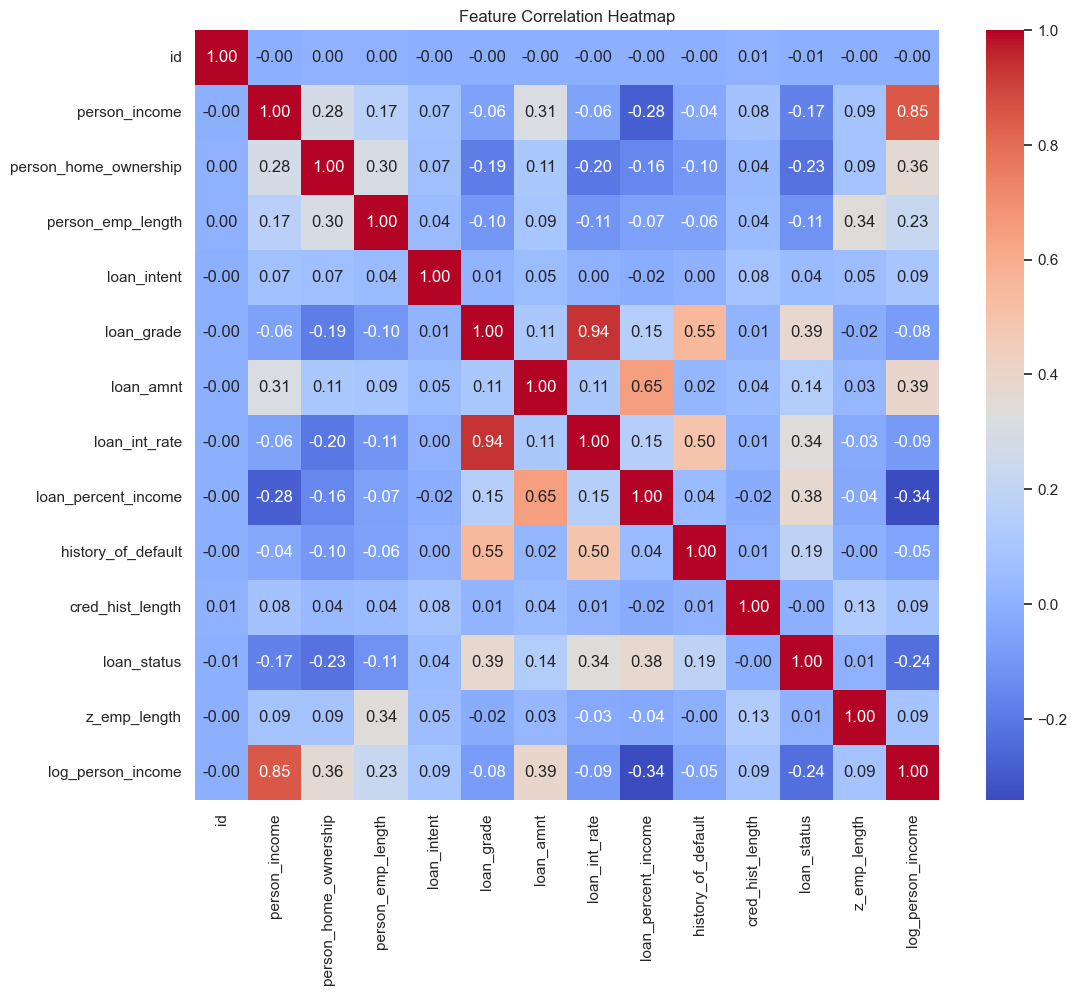

In [243]:
# Create a correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Loan grade and loan_int_rate are very highly correlated, but I will proabbly keep these predictors to categorize loan grade

<h3>Regression Models</h3>

In [245]:
df.head()

,id,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,history_of_default,cred_hist_length,loan_status,z_emp_length,log_person_income
0,0,35000,1,0.0,1,1,6000,11.49,0.17,0,14,0,1.187200,10.463132
1,1,56000,2,6.0,2,2,4000,13.35,0.07,0,2,0,0.328047,10.933125
2,2,28800,2,8.0,3,0,6000,8.90,0.21,0,10,0,0.833130,10.268165
3,3,70000,1,14.0,4,1,12000,11.11,0.17,0,5,0,2.348377,11.156265
4,4,60000,1,2.0,2,0,6000,6.92,0.10,0,3,0,0.682117,11.002117


In [250]:
target_cols = ['loan_status']
features = [col for col in df.columns if col not in target_cols]

# Already converted all my categorical variables into numerical
num_features = [col for col in features if df[col].dtype != "object"]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_features)
    ],
    sparse_threshold=0
)

X_processed = preprocessor.fit_transform(df[features])

df_transformed = pd.DataFrame(X_processed, columns=num_features)
print(df_transformed.head())

         id  person_income  person_home_ownership  person_emp_length  \
0 -0.999522      -0.696970                    0.0               -0.8   
1 -0.999488      -0.060606                    0.5                0.4   
2 -0.999454      -0.884848                    0.5                0.8   
3 -0.999420       0.363636                    0.0                2.0   
4 -0.999386       0.060606                    0.0               -0.4   

   loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0    -0.666667         0.0  -0.285714       0.144814             0.250000   
1    -0.333333         0.5  -0.571429       0.508806            -0.583333   
2     0.000000        -0.5  -0.285714      -0.362035             0.583333   
3     0.333333         0.0   0.571429       0.070450             0.250000   
4    -0.333333        -0.5  -0.285714      -0.749511            -0.333333   

   history_of_default  cred_hist_length  z_emp_length  log_person_income  
0                 0.0        

In [252]:
# Split features and targets
X_processed = df_transformed

y_class = df['loan_status'].astype(int)  # Ensure binary target is integer (0/1)
y_reg = df['log_person_income'] # normally distributed

# Split into training and test sets (70/30 split)
# we are using the same training set but distinct targets for the classification & regression models
X_train, X_test, y_class_train, y_class_test = train_test_split(X_processed, y_class, test_size=0.3, random_state=42)
_, _, y_reg_train, y_reg_test = train_test_split(X_processed, y_reg, test_size=0.3, random_state=42)

In [253]:
# Using sklearn.model_selection
# Linear Regression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_reg_train)
y_pred_lin = lin_reg.predict(X_test)
r2_lin = r2_score(y_reg_test, y_pred_lin)
mse_lin = mean_squared_error(y_reg_test, y_pred_lin)
mae_lin = mean_absolute_error(y_reg_test, y_pred_lin)

print("Linear Regression R²:", r2_lin, "MSE:", mse_lin, "MAE:", mae_lin)

Linear Regression R²: 1.0 MSE: 2.9204984908906125e-30 MAE: 1.6144987475187845e-15


R^2 value indicates how much of our predictions (loan_status and log_person_income) can be explained by the model. A value of 1.0 means that all of our predictions can be explained by the model.

Mean squared error (MSE) is a measure of estimation error. The smaller the error, the better the estimator. Our value is really small, so our model is a good estimation for our predictions.

Mean absolute error (MAE) is a measure of the average size of mistakes in a collection of predictions. The smaller the MAE, the better and more accurate a model. Our value is really small, so our model is accurate for our predictions.

In [254]:
# Might have to do this differently with person_income instead of log_person_income
# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_reg_train)
y_pred_dt = dt_reg.predict(X_test)
r2_dt = r2_score(y_reg_test, y_pred_dt)
mse_dt = mean_squared_error(y_reg_test, y_pred_dt)
print("Decision Tree Regressor R²:", r2_dt, "MSE:", mse_dt)

Decision Tree Regressor R²: 0.9999380917896902 MSE: 1.2806108111460159e-05


R^2 value indicates how much of our predictions (loan_status and log_person_income) can be explained by the model. A value of 0.99 means that 99% of our predictions can be explained by the model.

Mean squared error (MSE) is a measure of estimation error. The smaller the error, the better the estimator. Our value is really small, so our model is a good estimation for our predictions.

In [255]:
rf_reg = RandomForestRegressor(n_estimators=10, random_state=42)
rf_reg.fit(X_train, y_reg_train)
y_pred_rf = rf_reg.predict(X_test)
r2_rf = r2_score(y_reg_test, y_pred_rf)
mse_rf = mean_squared_error(y_reg_test, y_pred_rf)
print("Random Forest Regressor R²:", r2_rf, "MSE:", mse_rf)

Random Forest Regressor R²: 0.9998597312251165 MSE: 2.9015490624424933e-05


R^2 value indicates how much of our predictions (loan_status and log_person_income) can be explained by the model. A value of 0.99 means that 99% of our predictions can be explained by the model.

Mean squared error (MSE) is a measure of estimation error. The smaller the error, the better the estimator. Our value is really small, so our model is a good estimation for our predictions.

<h3>Classification Models</h3>
This is primarily what we're looking at - whether or not we can predict loan approval, and if so, which factors affect loan approval.

Logistic Regression Accuracy: 0.8952085487762841


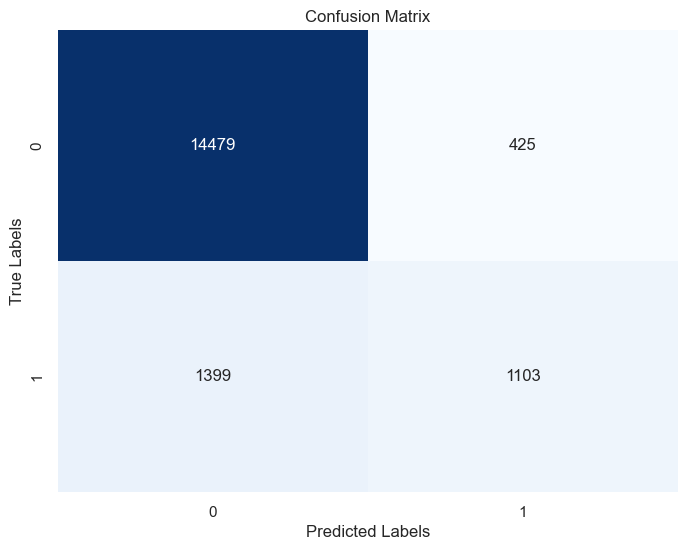

Precision: 0.7218586387434555
Recall: 0.44084732214228617
F1-Score: 0.547394540942928


In [256]:
# Logistic Regression for Classification
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train, y_class_train)
y_pred_log = log_reg.predict(X_test)

acc_log = accuracy_score(y_class_test, y_pred_log)
print("Logistic Regression Accuracy:", acc_log)

cm =  confusion_matrix(y_class_test, y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

precision = precision_score(y_class_test, y_pred_log)
recall = recall_score(y_class_test, y_pred_log)
f1 = f1_score(y_class_test, y_pred_log)
##roc_auc = roc_auc_score(y_class_test, y_prob_class)  # Typically y_prob_class[:,1] if using predict_proba

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
#print("ROC-AUC:", roc_auc)

Our precision value tells us how many of our true positives (in quadrant 2, top left) are in the total positives. The higher our precision value, the lower false positives our model predicts. 72% of our total positives are our true positives.

Our recall value is the proportion of true positives over the sum of true positives and false negatives (essentially a positive). Our recall value is in the middle at 0.44, which indicates that the model is okay at identifying positive data.

The F1-score is a balance between precision and recall. A high F1-score means the model is performing well with the opposite about a low F1-score. Our F1-score is in the middle, so our model neither performs really well or really poor.

In [258]:
# Might have to do this with person_income instead of log_person_income
# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=50,max_depth=5)
dt_clf.fit(X_train, y_class_train)
y_pred_dt_clf = dt_clf.predict(X_test)
acc_dt_clf = accuracy_score(y_class_test, y_pred_dt_clf)
print("Decision Tree Classifier Accuracy:", acc_dt_clf)
print("Confusion Matrix:\n", confusion_matrix(y_class_test, y_pred_dt_clf))

Decision Tree Classifier Accuracy: 0.9395036194415719
Confusion Matrix:
 [[14813    91]
 [  962  1540]]


In [259]:
# Might have to do this with person_income instead of log_person_income
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_class_train)
y_pred_rf_clf = rf_clf.predict(X_test)
acc_rf_clf = accuracy_score(y_class_test, y_pred_rf_clf)
print("Random Forest Classifier Accuracy:", acc_rf_clf)
print("Confusion Matrix:\n", confusion_matrix(y_class_test, y_pred_rf_clf))

Random Forest Classifier Accuracy: 0.9489831092726646
Confusion Matrix:
 [[14754   150]
 [  738  1764]]


<h3>Interpreting Results</h3>
<h4>Regression Coefficients</h4>

In [260]:
# Getting Regression Coefficients
coefficients = lin_reg.coef_
coef_series = pd.Series(coefficients, index=X_train.columns)
print("Regression Coefficients:")
print(coef_series.sort_values(ascending=False))

Regression Coefficients:
log_person_income        5.798080e-01
loan_amnt                9.971237e-16
loan_grade               1.352985e-16
person_emp_length        1.199451e-16
z_emp_length             2.858332e-17
cred_hist_length         1.884867e-17
id                      -5.327535e-17
loan_intent             -1.251849e-16
history_of_default      -1.426084e-16
person_income           -3.608225e-16
loan_int_rate           -3.842064e-16
person_home_ownership   -5.858322e-16
loan_percent_income     -1.053955e-15
dtype: float64


<h4>Log Odds for Logistic Regression</h4>

In [261]:
log_odds = log_reg.coef_  # This returns a 2D array (for binary classification, shape is (1, n_features))
log_odds_series = pd.Series(log_odds[0], index=X_train.columns)
print("Logistic Regression Log Odds:")
print(log_odds_series.sort_values(ascending=False))

Logistic Regression Log Odds:
loan_grade               2.441955
loan_percent_income      1.302600
loan_intent              0.433553
z_emp_length             0.187075
person_income            0.033547
cred_hist_length        -0.010637
id                      -0.046768
loan_amnt               -0.079647
person_emp_length       -0.154899
history_of_default      -0.177105
loan_int_rate           -0.280579
log_person_income       -0.505874
person_home_ownership   -1.100063
dtype: float64


<h4>Visualizing a Decision Tree</h4>

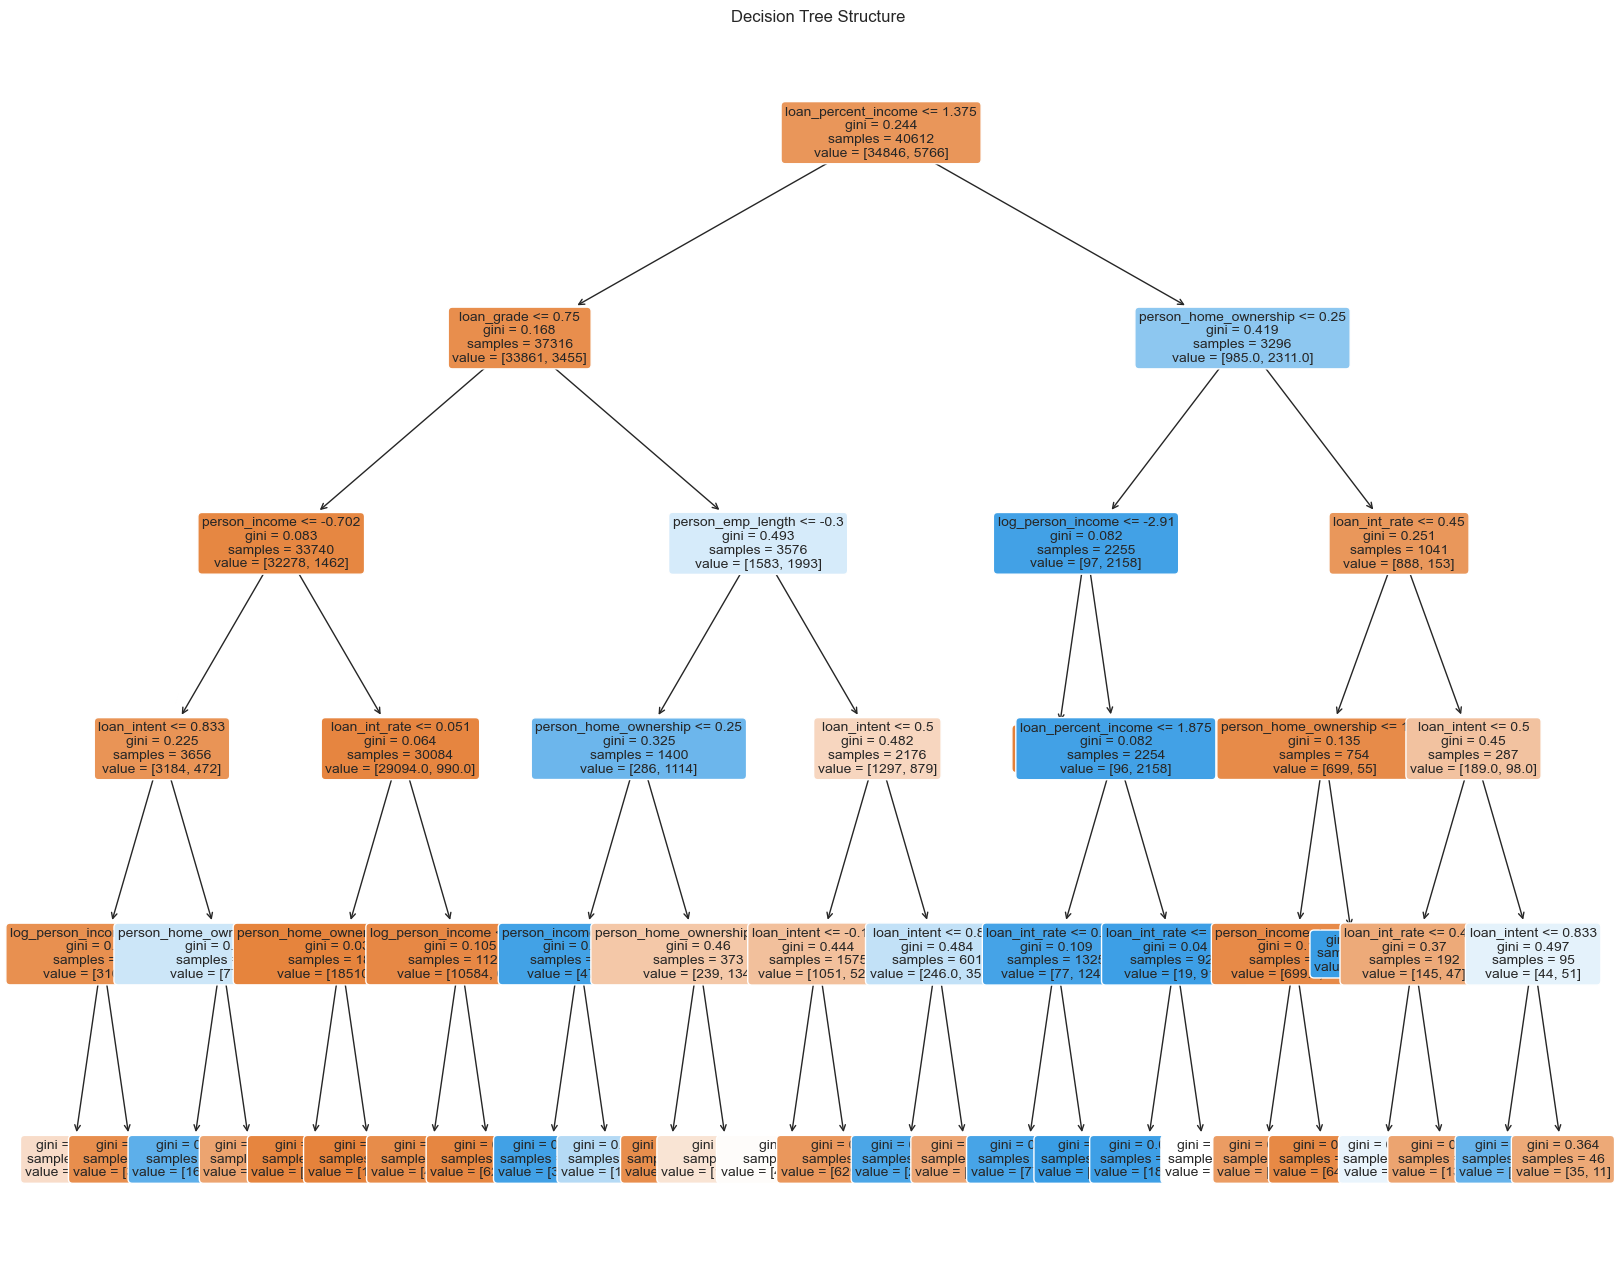

In [262]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 16))
plot_tree(dt_clf, feature_names=X_train.columns, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Structure")
plt.show()

<h4>Hyperparameter Tuning</h4>

In [263]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid. You can play around with different grids or make a giant one with a lot of numbers.

param_grid = {
    'criterion': ['gini', 'entropy'],  # Splitting criteria
    'max_depth': [None, 5, 10, 20],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],       # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}


# Assume rf_reg is your RandomForestRegressor instance
grid_search = GridSearchCV(estimator= dt_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_class_train)


print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validated accuracy:", grid_search.best_score_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Cross-Validated accuracy: 0.9464197911554567


In [264]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Display selected columns, e.g., parameters and mean test score
results_df[['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.911135,0.003225
1,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.918423,0.002224
2,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.926844,0.002458
3,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.922314,0.002029
4,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.923373,0.002757
...,...,...,...
211,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.922240,0.003385
212,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.925441,0.001124
213,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.929577,0.001715
214,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.929577,0.001715


<h3>Support Vector Machine (SVM) Model</h3>